## 前処理と特徴量選択

### 欠測値

削除は`pandas.DataFrame.dropna()`など

補完は`sklearn.preprocessing.Imputer`など

### カテゴリーデータ

量的変数でない（数値でない）データを扱う時のやり方。
大中小、良い普通悪いなど順序がある場合は順序に応じて数値データにする。
順序がない場合、`OneHotEncoder`を使う。

### 標準化

変数を平均0, 標準偏差1であるように一次変換する。
変数$x$の平均が$\mu$で標準偏差が$\sigma$のとき、標準化$z=\frac{x-\mu}{\sigma}$とする。

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
x=np.arange(0,2.1,0.1)
x=x.reshape(-1,1)
x_std=StandardScaler().fit_transform(x)
print(x.reshape(1,-1))
print(x_std.reshape(1,-1))

[[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
   1.4  1.5  1.6  1.7  1.8  1.9  2. ]]
[[-1.65144565 -1.48630108 -1.32115652 -1.15601195 -0.99086739 -0.82572282
  -0.66057826 -0.49543369 -0.33028913 -0.16514456  0.          0.16514456
   0.33028913  0.49543369  0.66057826  0.82572282  0.99086739  1.15601195
   1.32115652  1.48630108  1.65144565]]


### 特徴量選択

過学習を防ぐ（バリアンスを下げる）ために単純なモデルを使いたい。
そのための一つのやり方は変数（特徴量）を選ぶこと。
また正則化を用いることもできる。これについては後述する。

- L1正則化を使う
- ランダムフォレストを使う

ランダムフォレストによる特徴量選択。
各変数による不純度の低下の様子で変数の重要度を判断する。

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
df_wine=pd.read_csv('wine.csv')
feat_labels=df_wine.columns[2:]
df_wine.head()

,Unnamed: 0,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
import os
os.getcwd()

'/Users/sugakubunka/Documents/umezaki/bunka/pythonML'

In [4]:
from sklearn.model_selection import train_test_split

X,y=df_wine.iloc[:,2:].values,df_wine.iloc[:,1].values
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.3)

forest=RandomForestClassifier(n_estimators=10000)
forest.fit(X_train,y_train)
importances=forest.feature_importances_
indices=np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print('%2d) %-*s %f' %
          (f+1, 30, feat_labels[indices[f]],importances[indices[f]]))

 1) Proline                        0.192004
 2) Flavanoids                     0.168375
 3) Color intensity                0.151074
 4) OD280/OD315 of diluted wines   0.114636
 5) Alcohol                        0.109925
 6) Hue                            0.075399
 7) Total phenols                  0.059612
 8) Malic acid                     0.030077
 9) Alcalinity of ash              0.028257
10) Proanthocyanins                0.023852
11) Magnesium                      0.022245
12) Ash                            0.012658
13) Nonflavanoid phenols           0.011886


### 課題
上で選んだ特徴量を用いた学習により、バリアンスが実際に下がっているかどうか学習曲線を見てみよう。

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [6]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/Users/sugakubunka/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/pyplot.py'>

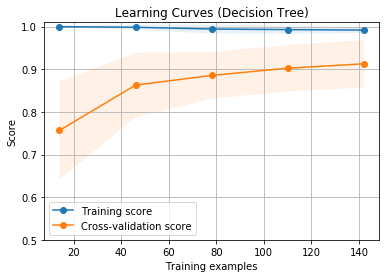

In [7]:
title = "Learning Curves (Decision Tree)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = DecisionTreeClassifier(criterion='entropy', max_depth=3)
plot_learning_curve(estimator, title, X, y, ylim=(0.5, 1.01), cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from '/Users/sugakubunka/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/pyplot.py'>

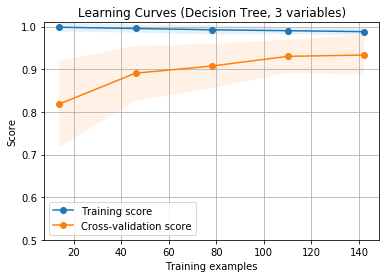

In [8]:
X_selected, y_selected = X[:,(-1,-4,-7)], y
title = "Learning Curves (Decision Tree, 3 variables)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = DecisionTreeClassifier(criterion='entropy', max_depth=3)
plot_learning_curve(estimator, title, X_selected, y_selected, ylim=(0.5, 1.01), cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from '/Users/sugakubunka/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/pyplot.py'>

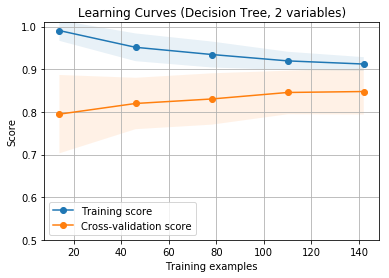

In [9]:
X_selected, y_selected = X[:,(-1,-4)], y
title = "Learning Curves (Decision Tree, 2 variables)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = DecisionTreeClassifier(criterion='entropy', max_depth=3)
plot_learning_curve(estimator, title, X_selected, y_selected, ylim=(0.5, 1.01), cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from '/Users/sugakubunka/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/pyplot.py'>

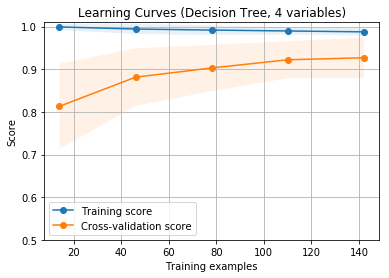

In [10]:
X_selected, y_selected = X[:,(-1,-2,-4,-7)], y
title = "Learning Curves (Decision Tree, 4 variables)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = DecisionTreeClassifier(criterion='entropy', max_depth=3)
plot_learning_curve(estimator, title, X_selected, y_selected, ylim=(0.5, 1.01), cv=cv, n_jobs=4)

In [11]:
from sklearn.model_selection import cross_val_score
X_selected, y_selected = X[:,(-1,-4,-7,-13)], y
estimator = DecisionTreeClassifier(criterion='entropy', max_depth=3)
scores=cross_val_score(estimator,X_selected,y_selected,cv=40)
print('Accuracy: %0.2f(+/- %0.2f)' % (scores.mean(), scores.std() *2))

Accuracy: 0.95(+/- 0.20)


上の三つの結果を比べる。
特徴量を重要度が高いものから3つ選んだモデルでは、元のモデルと比べてバイアスはほぼ変わらないがバリアンスは下がった。
特徴量を重要度が高いものから2つ選んだモデルでは、元のモデルと比べてバイアスが上がった。
この三つのモデルの中では、特徴量を3つ選んだモデルが一番良いと言える。

### L1正則化による特徴量選択

L1正則化の強さを変えて、有効な特徴量を選ぶ。
パラメータの変化を可視化する。

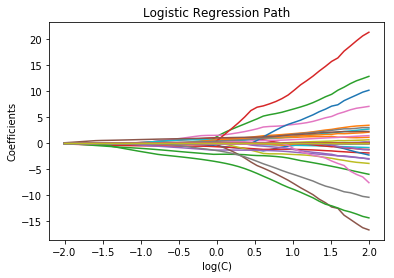

In [12]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt

cs = np.logspace(-2, 2)

X=df_wine.iloc[:,2:]
y=df_wine.iloc[:,1]

clf = LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_.append(clf.coef_.ravel().copy())

coefs_ = np.array(coefs_)
plt.plot(np.log10(cs), coefs_)
ymin, ymax = plt.ylim()
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Path')
plt.axis('tight')
plt.show()

### 主成分分析
特徴量選択では単に変数の数を減らすだけ。主成分では新しい変数を作る。  
分散が大きい=情報量が多い、という基準で、分散が大きい変数を新しく作る。
それと直交する方向（残りの情報を拾う）に次の変数を作っていく。（計量にどういう意味があるか？）

標準化が重要。

(-2.1512772984429009,
 2.2998232919334707,
 -2.7195560240367076,
 2.7532649158540146)

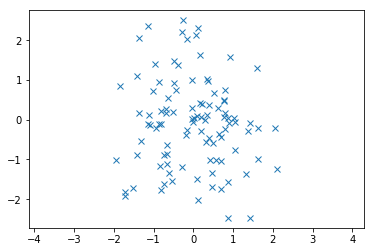

In [13]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
mean = [0, 0]
cov = [[1,0], [0,1]]
x, y = np.random.multivariate_normal(mean, cov, 100).T
plt.plot(x, y, 'x')
plt.axis('equal')

[ 0.6086621  0.3913379]


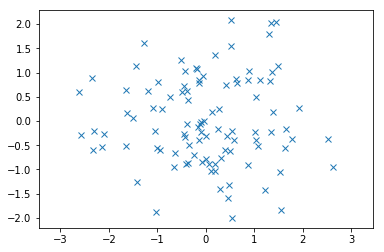

In [14]:
X=np.array([x,y]).transpose()
pca=PCA(n_components=2)
pca.fit(X)
X_r=pca.transform(X)
plt.plot(X_r[:,0], X_r[:,1], 'x')
plt.axis('equal')
print(pca.explained_variance_ratio_)

explained variance ratio (first two components): [ 0.92461621  0.05301557]


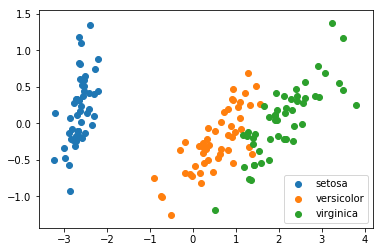

In [15]:
#http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html
from sklearn import datasets
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

iris=datasets.load_iris()
X,y,target_names=iris.data,iris.target,iris.target_names
pca=PCA(n_components=2)
pca.fit(X)
X_r=pca.transform(X)

#Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
for i in range(len(target_names)):
    plt.scatter(X_r[y==i,0],X_r[y==i,1],label=target_names[i])
plt.legend()

In [16]:
import pandas as pd
df_wine=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',header=None)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X,y=df_wine.iloc[:,1:].values,df_wine.iloc[:,0].values
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.3)
sc=StandardScaler()
X_train_std=sc.fit_transform(X_train)
X_test_std=sc.transform(X_test)

In [17]:
import numpy as np
cov_mat=np.cov(X_train_std.T)
eigen_vals,eigen_vecs=np.linalg.eig(cov_mat)
print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[ 4.54635908  2.60679412  1.57643945  0.97617826  0.80896281  0.69016038
  0.52422216  0.11266655  0.3499802   0.29789215  0.16684696  0.23331694
  0.215872  ]


explained variance ratio (first two components): [ 0.92461621  0.05301557]


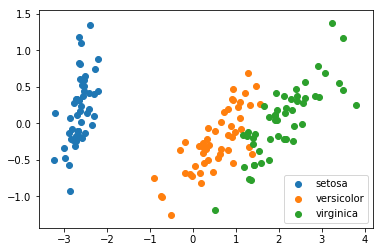

In [18]:
#http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html
from sklearn import datasets
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

iris=datasets.load_iris()
X,y,target_names=iris.data,iris.target,iris.target_names
pca=PCA(n_components=2)
pca.fit(X)
X_r=pca.transform(X)

#Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
for i in range(len(target_names)):
    plt.scatter(X_r[y==i,0],X_r[y==i,1],label=target_names[i])
plt.legend()

explained variance ratio (first two components): [ 0.14890594  0.13618771]


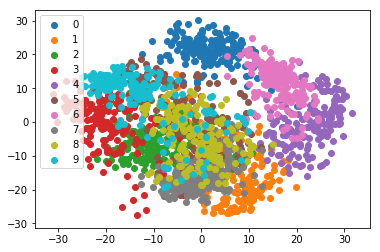

In [19]:
#手書き文字を主成分分析する
from sklearn import datasets
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

digits=datasets.load_digits()
X,y,target_names=digits.data,digits.target,digits.target_names
pca=PCA(n_components=2)
pca.fit(X)
X_r=pca.transform(X)

#Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
for i in range(len(target_names)):
    plt.scatter(X_r[y==i,0],X_r[y==i,1],label=target_names[i])
plt.legend()

In [20]:
#主成分分析をした後、分類手法を試してみる。
#例えば決定木の精度を上げることができるか
pca=PCA(n_components=10)
pca.fit(X)
X_r=pca.transform(X)
#Percentage of variance explained for each components
print('explained variance ratio: %s'
      % str(pca.explained_variance_ratio_))
pca.explained_variance_ratio_.sum()

explained variance ratio: [ 0.14890594  0.13618771  0.11794594  0.08409979  0.05782415  0.0491691
  0.0431598   0.0366137   0.03353244  0.03078793]


0.7382264933428242

### カーネル主成分

カーネルトリック。
非線形な$\phi\colon R^n\to R^m$でデータを変換し、その後線形なアルゴリズムを適用する。
アルゴリズムがデータの内積のみ必要な場合、
内積$(\phi(x^{(i)}),\phi(x^{(j)}))$を直接計算する代わりに$k(x^{(i)},x^{(j)})$を利用する。
カーネルは類似度として解釈されることもある。

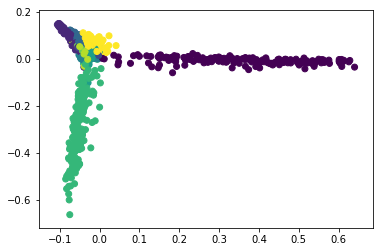

In [21]:
#手書き文字をkernel主成分分析する
from sklearn import decomposition, datasets
import matplotlib.pyplot as plt
%matplotlib inline

digits=datasets.load_digits()
pca = decomposition.KernelPCA(n_components=2,kernel='rbf',gamma=.003)
pca.fit(digits.data)
X = pca.transform(digits.data)
plt.scatter(X[:, 0], X[:, 1], c=digits.target)

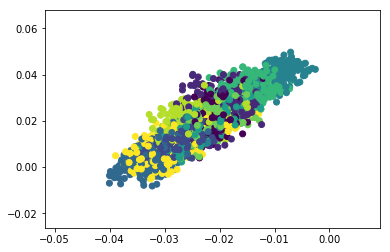

In [22]:
#手書き文字をkernel主成分分析する
from sklearn import decomposition, datasets
import matplotlib.pyplot as plt
%matplotlib inline

digits=datasets.load_digits()
pca = decomposition.SparsePCA(n_components=2)
pca.fit(digits.data)
X = pca.transform(digits.data)
plt.scatter(X[:, 0], X[:, 1], c=digits.target)